## **##### 1.Importing necessary libraries**

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance



## **##### 2.Loading datasets**

In [79]:
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')
train = pd.read_csv('./train.csv')

## **##### 3.Miss information analysis**

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float6

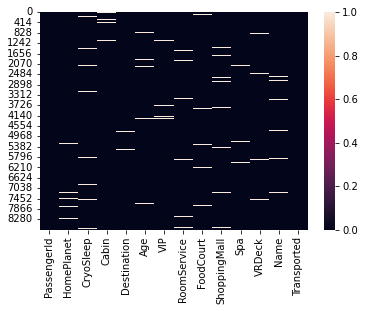

In [3]:
print(train.isnull().sum())
sns.heatmap(train.isnull())
print(train.info())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name         

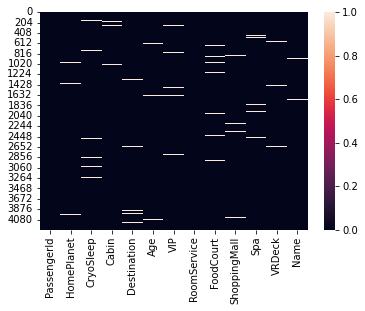

In [4]:
print(test.isnull().sum())
sns.heatmap(test.isnull())
print(test.info())

## **##### 4.Preprocessing**

In [5]:
################################################################
## The passengers were all from the same ship. This means we  ##
## don't have to search for lost information separately.      ##
################################################################

In [6]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

In [7]:
params_XGB_best ={'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 725, #initial value is 651
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}

In [8]:
def t_fold(X,y,n_splits): 
    params= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 7250, #initial value is 725
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1,
             'early_stopping_rounds':200,}
    results=[]
    n_iterations=[]
    skf = StratifiedKFold(n_splits=n_splits)
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**params).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        n_iteration = model.get_booster().best_iteration
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        i=int(sum(n_iterations)/len(n_iterations))
    print("Average n_ite=" + str(i))
    print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    print (n)
    print("FIIINISH__________________________________\n")
    return n

In [80]:
train_test=train.append(test)

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


<AxesSubplot:>

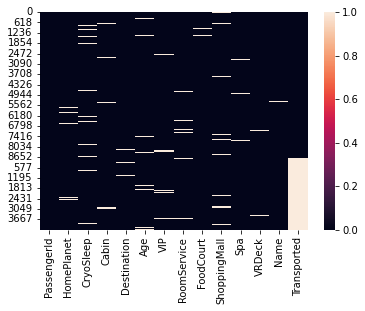

In [10]:
print(train_test.isnull().sum())
sns.heatmap(train_test.isnull())

## ##### **4.1.Expenses+CryoSleep**

In [81]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [12]:
################################################################################################################
### Let's fill in missing cost with "0" if a passenger was in CryoSleep. If you sleep you don't spend money. ###
################################################################################################################

In [82]:
train_test.loc[:,Expenses_columns]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

## **##### 4.2.CryoSleep + Expenses**

In [14]:
#############################################################################################################
### From the description of the contest guidelines we can conclude that if a person is in cryosleep,      ###
### he cannot spend money to buy additional services. Moreover, when filling in the missing information   ###
### in the columns: 'Age,RoomService, FoodCourt, ShoppingMall, Spa, VRDec'k, we should remember this      ###
### same feature of cryosleep. Let's fill in the missing information based on this conclusion.            ###
#############################################################################################################

In [15]:
################################################################################
### First of all, let's create an additional column and call it "expenses".  ###
### Expenses = Age + RoomService + FoodCourt + ShoppingMall + Spa + VRDec'k  ###
################################################################################

In [83]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

In [84]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

## **##### 4.3.Name**

In [18]:
################################################################################
### I am not sure that we are able to restore some information about Names.  ###
### Let's fill in this columns with "Unknown Unknown", because maybe in the  ###
### future we will have to split the column.                                 ###
################################################################################


In [85]:
train_test.Name = train_test.Name.fillna('Unknown Unknown')

## **##### 4.4.Cabin**

In [20]:
##################################################################
### We have to check PassengerId carefully. Because it         ###
### contains room numbers. So it will help us to find          ###
### the miss Cabin, VIP status, HomePlanet and Destination.    ###
##################################################################

In [86]:
train_test.loc[:,['Room']] = train_test.PassengerId.apply(lambda x: x[0:4] )
#Here I want to create handbooks to fill in informations in Cabin, VIP status, HomePlanet and Destination.
guide_VIP=train_test.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=train_test.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=train_test.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=train_test.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
train_test=pd.merge(train_test,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_VIP,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [87]:
train_test.loc[:,['VIP']]=train_test.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['Destination']]=train_test.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [23]:
train_test[train_test.Cabin.isnull()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,908.0,0012,NaN,False,Earth,TRAPPIST-1e
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True,0.0,0101,NaN,False,Mars,TRAPPIST-1e
222,0239_01,Mars,False,NaN,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,Diedow Resty,False,1048.0,0239,NaN,False,Mars,TRAPPIST-1e
272,0301_01,Earth,True,NaN,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Margia Wriggins,False,0.0,0301,NaN,False,Earth,TRAPPIST-1e
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,4476.0,241.0,Naviton Coudered,False,4947.0,0310,NaN,False,Europa,TRAPPIST-1e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,9058_01,Mars,False,NaN,TRAPPIST-1e,38.0,NaN,784.0,0.0,42.0,38.0,10.0,Hammet Muff,NaN,874.0,9058,NaN,NaN,Mars,TRAPPIST-1e
12902,9138_01,Europa,NaN,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,Misamak Trupistic,NaN,3888.0,9138,NaN,False,Europa,TRAPPIST-1e
12941,9223_01,Mars,True,NaN,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Weessh Sun,NaN,0.0,9223,NaN,False,Mars,TRAPPIST-1e
12942,9223_02,Mars,True,NaN,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,Perit Sun,NaN,0.0,9223,NaN,False,Mars,TRAPPIST-1e


PassengerId         0
HomePlanet        157
CryoSleep         174
Cabin             162
Destination       154
Age               270
VIP               172
RoomService       170
FoodCourt         180
ShoppingMall      175
Spa               177
VRDeck            177
Name                0
Transported      4277
Expenses            0
Room                0
Cabin_y           162
VIP_y             172
HomePlanet_y      157
Destination_y     154
dtype: int64


<AxesSubplot:>

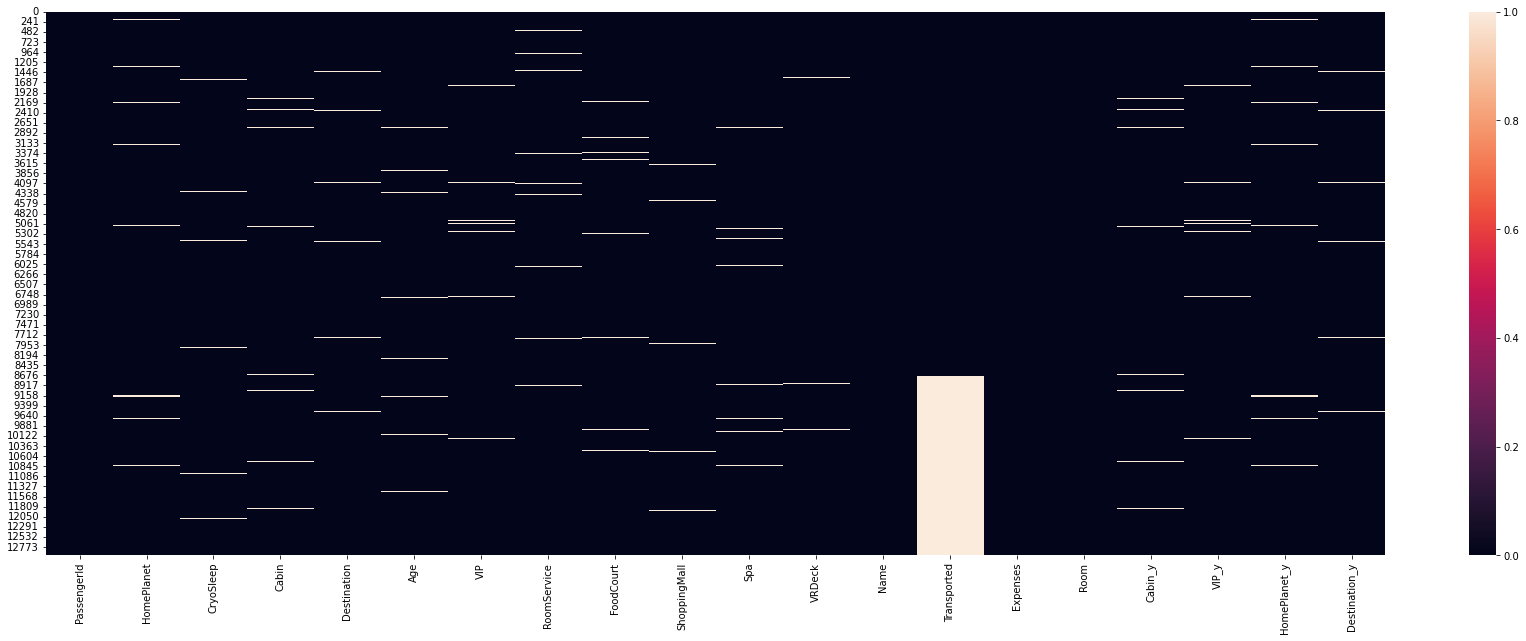

In [24]:
fig,ax = plt.subplots(figsize=(30,10))
pd.set_option('display.max_rows', 100)
print(train_test.isnull().sum())
sns.heatmap(train_test.isnull())

## **##### 4.5.Age**

In [25]:
##########################################################################
### Let's see how Age depends on other columns to find some miss data. ###
##########################################################################

<AxesSubplot:>

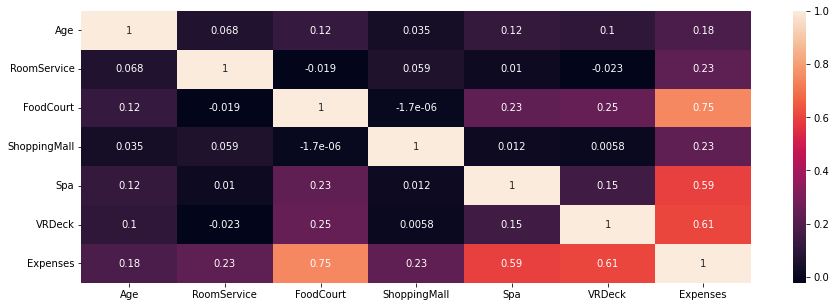

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(train_test.corr(),annot=True)

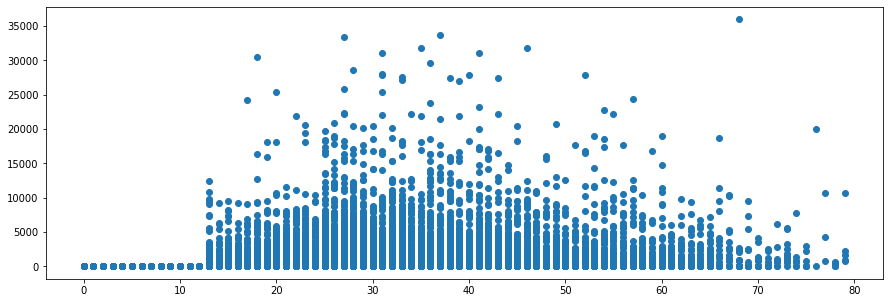

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
analys = train_test.loc[:,['Age','Expenses']]
ax.scatter(analys.Age,analys.Expenses)

PassengerId         0
HomePlanet        157
CryoSleep         174
Cabin             162
Destination       154
Age               270
VIP               172
RoomService       170
FoodCourt         180
ShoppingMall      175
Spa               177
VRDeck            177
Name                0
Transported      4277
Expenses            0
Room                0
Cabin_y           162
VIP_y             172
HomePlanet_y      157
Destination_y     154
dtype: int64


<AxesSubplot:>

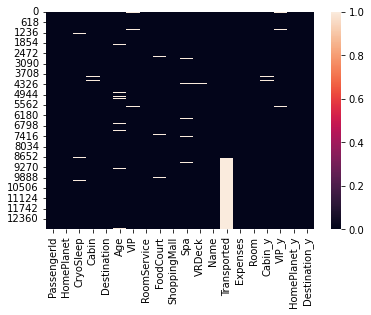

In [28]:
pd.set_option('display.max_rows', 100)
print(train_test.isnull().sum())
sns.heatmap(train_test.isnull())

## **##### 4.6.HomePlanet + Destination.**

In [29]:
analys = train_test.loc[:,['HomePlanet','Destination']]
analys['numeric'] =1
analys.groupby(['Destination','HomePlanet']).count()

numeric
Destination   HomePlanet         
55 Cancri e   Earth           995
              Europa         1343
              Mars            299
PSO J318.5-22 Earth          1083
              Europa           29
              Mars             68
TRAPPIST-1e   Earth          4737
              Europa         1780
              Mars           2328

PassengerId         0
HomePlanet        157
CryoSleep         174
Cabin             162
Destination       154
Age               270
VIP               172
RoomService       170
FoodCourt         180
ShoppingMall      175
Spa               177
VRDeck            177
Name                0
Transported      4277
Expenses            0
Room                0
Cabin_y           162
VIP_y             172
HomePlanet_y      157
Destination_y     154
dtype: int64


<AxesSubplot:>

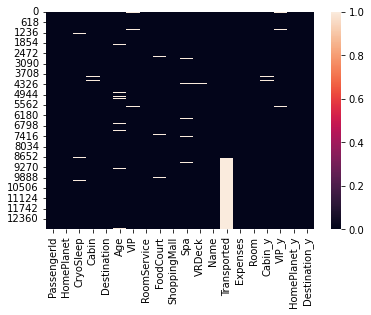

In [30]:
pd.set_option('display.max_rows', 100)
print(train_test.isnull().sum())
sns.heatmap(train_test.isnull())

## **##### 4.7.Split Cabin.**

In [31]:
#######################################################
### Let's split the column and drop usless columns. ###
#######################################################

In [88]:
train_test.loc[:,['Cabin_1']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_2']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_3']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

In [89]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]
train_test['Name_key']=train_test['SecondName']+train_test['Room']

In [90]:
train_test['Age_group'] = 0
train_test.loc[train_test['Age']  == 0, 'Age_group'] = 1
train_test.loc[(train_test['Age'] > 0) & (train_test['Age'] <= 10), 'Age_group']=2
train_test.loc[(train_test['Age'] > 10) & (train_test['Age'] <= 20), 'Age_group']=3
train_test.loc[(train_test['Age'] > 20) & (train_test['Age'] <= 30), 'Age_group']=4
train_test.loc[(train_test['Age'] > 30) & (train_test['Age'] <= 50), 'Age_group']=5
train_test.loc[(train_test['Age'] > 50) & (train_test['Age'] <= 60), 'Age_group']=6
train_test.loc[(train_test['Age'] > 60) & (train_test['Age'] <= 70), 'Age_group']=7
train_test.loc[train_test['Age']  > 70, 'Age_group'] = 8

## **##### 4.8.Let's apply SimpleImputer + OneHotEncoder.**

In [91]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination', 'Age_group']
transported=['Transported']
#notvg = ['HomePlanet','VIP','ShoppingMall','FoodCourt','Age','Cabin_2','Destination']
train_test = train_test[num_cols+cat_cols+transported].copy()

num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)


train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns= ohe.get_feature_names_out())
train_test = train_test.drop(cat_cols,axis=1)
train_test = pd.concat([train_test,temp_train],axis=1)


## **##### 4.9.Let's split train and test set.**

In [92]:
train = train_test[train_test['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('int')
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [93]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [94]:
X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [95]:
print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.8063936119497855


## **##### 4.10.Let's deal with outliers.**

In [39]:
features_isolation =['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Age']

c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


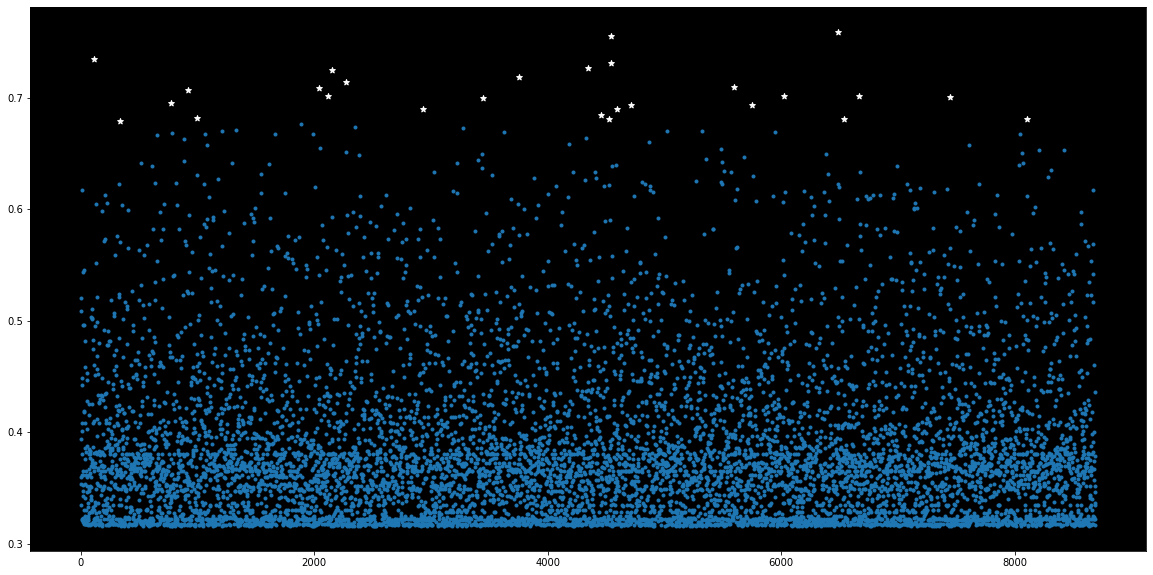

In [40]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(n_jobs=-1, random_state=1,n_estimators=100,contamination=0.003)
isf.fit(X[features_isolation], y)

rows = pd.DataFrame(isf.predict(X[features_isolation]),columns=['feature'])
rows_ind = rows[rows.feature == 1]
results = pd.DataFrame()
results['results'] = - isf.score_samples(X[features_isolation])
results['chance'] = isf.decision_function(X[features_isolation])
results['yes/no'] = isf.predict(X[features_isolation])

new = results[results['yes/no']==1]
old= results[results['yes/no']==-1]
fig,ax = plt.subplots(figsize=(20,10))
ax.set_facecolor('black')
ax = plt.scatter(new.index,new.results,marker=".")
ax = plt.scatter(old.index,old.results,color='white',marker="*")


In [41]:
X_1 = X.iloc[rows_ind.index].reset_index(drop=True)
y_1 = y.iloc[rows_ind.index].reset_index(drop=True) 

In [42]:
print(get_score(xgb.XGBClassifier(**params_XGB_best),X_1,y_1).mean())

0.8052141313949406


In [43]:
#############################################################
### I found no evidence for the use of IsolationForest.   ###
### The result got worse with different contamination.    ###
#############################################################

## **##### 4.11.Permutation Importance.**

<AxesSubplot:>

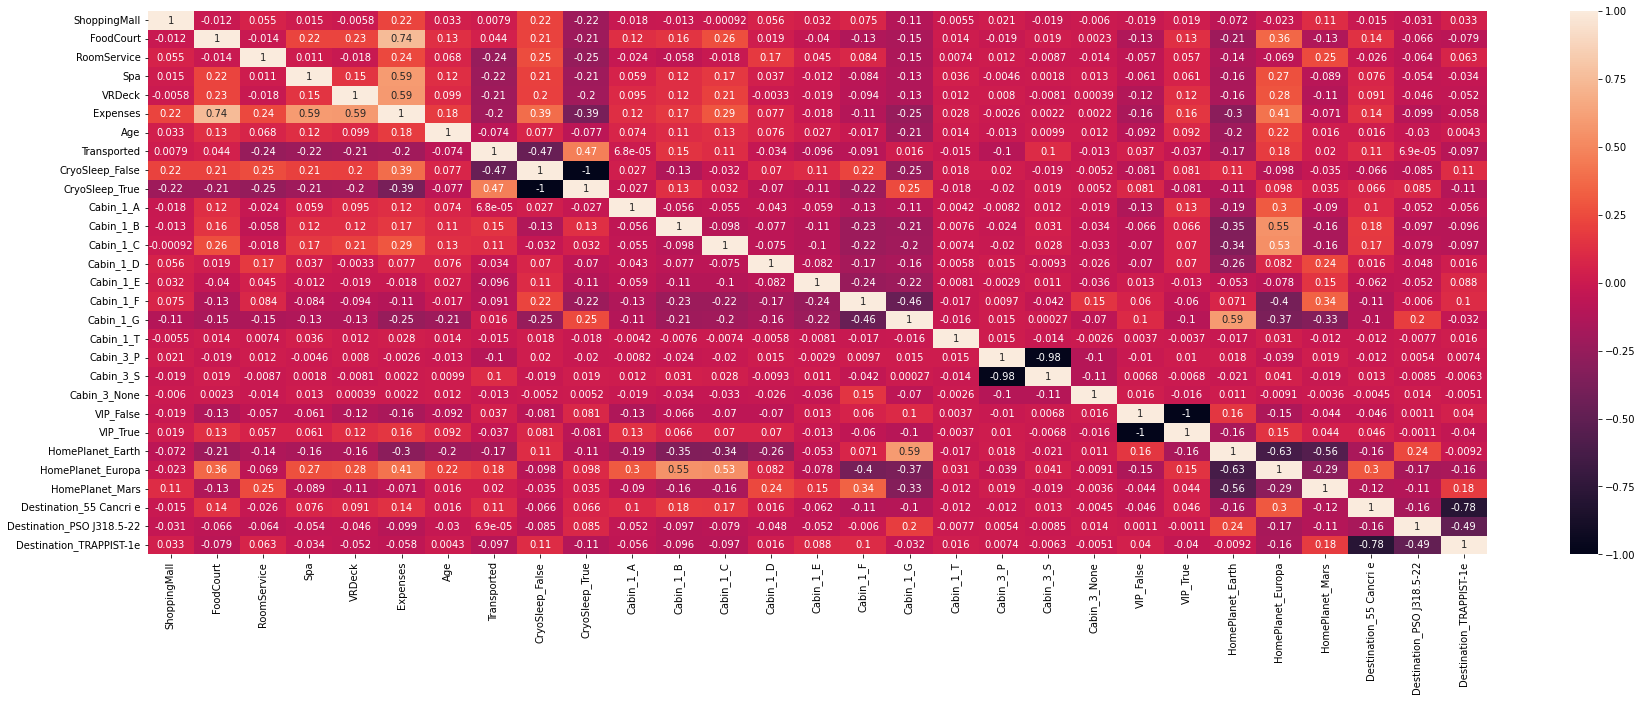

In [44]:
fig = plt.subplots(figsize=(30,10))   
sns.heatmap(train.corr(),annot=True)


In [45]:
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 725, #initial value is 651
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}

In [96]:
perm = PermutationImportance(xgb.XGBClassifier(**params_XGB_best), random_state=1,n_iter =10,cv=5).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist(),top=50)

Weight,Feature
0.0390 ± 0.0171,Spa
0.0363 ± 0.0098,FoodCourt
0.0363 ± 0.0131,VRDeck
0.0325 ± 0.0216,CryoSleep_False
0.0299 ± 0.0291,Expenses
0.0238 ± 0.0125,RoomService
0.0131 ± 0.0116,ShoppingMall
0.0073 ± 0.0062,Cabin_1_E
0.0072 ± 0.0062,Cabin_1_C
0.0068 ± 0.0106,Age


In [97]:
drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

In [98]:
X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

In [49]:
print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.8077761004290481


In [99]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=1, n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X, y)
X = X_sm
y = y_sm


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\imblearn\over_sampling\_smote\base.py:340: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  FutureWarning,


In [51]:
y.value_counts()

0    4378
1    4378
Name: Transported, dtype: int64

## **##### 5.Modeling**

In [52]:
###############################
# Let's define some settings ##
###############################
optuna_study = "ON"
LGBM_study = "OFF"
XGB_study = "OFF"
CAT_study = "OFF"


gpu_switch = "OFF"
skf = StratifiedKFold(n_splits=10)

## **##### 5.1. LGBM**

In [53]:
if gpu_switch == "ON":
    method = "gpu"
else:
    method = "cpu"

def objective(trial):
    param = {
     'objective': 'binary',
     'device': method,
     'metric': 'binary_logloss',
     'verbosity': -1,
     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
     'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
     'num_leaves': trial.suggest_int('num_leaves', 2, 512),
     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     'n_estimators' : trial.suggest_int('n_estimators', 100, 20000),
     'subsample':None,
     'subsample_freq':None,
     'reg_alpha':None,
     'colsample_bytree':None,
     'reg_lambda':None,
     'early_stopping_round':trial.suggest_int('early_stopping_round', 200, 200)
            }
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], yi.loc[test_index]
        model = lgb.LGBMClassifier(**param).fit(train_X,train_y,
                                            eval_set=[(valid_X,valid_y)],
                                            callbacks=[lgb.log_evaluation(period=0, show_stdv=False)]
                                             )  
        n_iteration = model.best_iteration_
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        i=int(sum(n_iterations)/len(n_iterations))
    print("Average n_ite=" + str(i))
    print("% of scatter =" + str(np.std(n_iterations)/i))
    n=sum(results)/len(results)
    print(n)
    print("FIIINISH__________________________________\n")
       
    return n

if optuna_study == LGBM_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=10000)
    print('Best trial:', study.best_trial.params)

In [54]:
#Trial 1468 finished with value: 0.8084681392022881
params_LGBM= {'lambda_l1': 6.183557865875619, 
              'lambda_l2': 0.011470762415538793, 
              'learning_rate': 0.08693013162698361, 
              'num_leaves': 330,
              'feature_fraction': 0.6583455294128855, 
              'bagging_fraction': 0.8666491286986552, 
              'bagging_freq': 1, 
              'min_child_samples': 17, 
              'n_estimators': 739}
#Average n_ite=739

## **##### 5.2. XGB**

In [55]:
if gpu_switch == "ON":
    method = "gpu_hist"
else:
    method = "hist"

def objective(trial):
    print("START__________________________________")
    param = {  
        'tree_method':method,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        #'early_stopping_rounds':200,
        }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    print (n)
    print("FIIINISH__________________________________\n")
    return n

if optuna_study == XGB_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=1000)

In [100]:
#Trial 82 finished with value: 0.8107728163567985
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 730, #initial value is 651
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}
#params_XGB_best = {'lambda': 3.3743332205741714, 'alpha': 0.32428793071193196, 'colsample_bytree': 0.9617886057986437, 'subsample': 0.9920684139493224, 'learning_rate': 0.09176585385718311, 'n_estimators': 570, 'max_depth': 4, 'min_child_weight': 6}
#Average n_ite=661

## **##### 6. Submission**

In [101]:
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X,y)).predict(test)
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('XGB_best.csv', index=False)